# Seto (2021) Signalling Scheme

This notebook is used for searching for galactic civilizations following the concurrent signalling and receiving schematic described by [Seto (2021)](https://iopscience.iop.org/article/10.3847/1538-4357/ac0c7b)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, QTable, vstack
import os

from astroquery.gaia import Gaia

from astropy.timeseries import LombScargle, TimeSeries
import random

import seto

We need the properties of the reference event -- position, distance, and distance error.

In [151]:
# Properties of SN1054 (Crab Nebula)
t0 = Time({'year': 1054, 'month': 7, 'day': 4}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1054')

# https://vizier.cds.unistra.fr/viz-bin/VizieR-4 database (photogeometric distance)
d0 = 1899.33655000 * u.pc
d0_err = (2193.16919000-1711.93213000)/2 * u.pc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [152]:
print(f'Relative distance error: {d0_err/d0:0.4f}')

Relative distance error: 0.1267


Some parameters defined by Seto are used below

In [188]:
deltaTE = Time.now() - t0 # time difference since arrival of SN signal to Earth
tauE = (const.c/d0.to('m'))*deltaTE.to('s') # Seto's 'normalized time'
q = 1 # Seto's mode -- we use the primary mode q = 1
maxTauE = np.sqrt(1+q**2) - 1 # if tauE is greater than this, there are no angle solutions

`thetaPlus` and `thetaMinus` are the angles of the two rings to observe -- their sum is $90^o$

`depthPlus` and `depthMinus` are the effective depths of the two rings

`dTheta` is the width of the rings, which is finite due to finite distance error

In [189]:
thetaPlus = (np.arctan(q) + np.arccos((1+tauE.value)/np.sqrt(1+q**2)))*u.rad
thetaMinus = (np.arctan(q) - np.arccos((1+tauE.value)/np.sqrt(1+q**2)))*u.rad
# angles to search

depthPlus = d0*np.cos(thetaPlus)
depthMinus = d0*np.cos(thetaMinus)
# effective search depths for the two angles

dTheta = (tauE*d0_err/(np.abs(np.cos(thetaPlus) - np.sin(thetaPlus))*d0))*u.rad

In [190]:
thetaMinus.to('deg')

<Quantity 9.84596391 deg>

In [120]:
depthMinus

<Quantity 1871.36129465 pc>

In [176]:
dTheta.to('deg')

<Quantity 0.18753567 deg>

Initialize the star objects

In [9]:
Gaia_file = '../Gaia_var_class.fits'
Gaia = Table.read(Gaia_file, format='fits')

In [10]:
c1 = SkyCoord(ra = Gaia['ra'],
              dec = Gaia['dec'],
              distance = Gaia['dist'],
              frame = 'icrs')
# in degrees, degrees, pc

Calculate the angular separations between the stars and the reference event

In [183]:
separations = c1.separation(c0)

Find the stars within the rings, regardless of distance

In [12]:
maskPlus = np.abs(separations.degree - thetaPlus.to('deg').value) < dTheta.to('deg').value
maskMinus = np.abs(separations.degree - thetaMinus.to('deg').value) < dTheta.to('deg').value

ringPlus = c1[maskPlus]
ringMinus = c1[maskMinus]

Find the stars within the rings and within the effective depths

In [13]:
distMaskMinus = ringMinus.distance < depthMinus
distMaskPlus = ringPlus.distance < depthPlus

ringPlusC = ringPlus[distMaskPlus]
ringMinusC = ringMinus[distMaskMinus]

### Other SNe

Properties taken from table in Seto (2021)

In [14]:
# Properties of SN1572 (Tycho)
tT = Time({'year': 1572, 'month': 11, 'day': 2}, format='ymdhms')

cT_radec = SkyCoord.from_name('SN 1572')

dT = 8970 * u.lyr
dT_err = 0.09*d0

cT = SkyCoord(ra=cT_radec.ra, dec=cT_radec.dec, distance=dT)

In [15]:
# Properties of SN1604 (Kepler)
tK = Time({'year': 1604, 'month': 10, 'day': 9}, format='ymdhms')

cK_radec = SkyCoord.from_name('SN 1604')

dK = 16600 * u.lyr
dK_err = 0.14*d0

cK = SkyCoord(ra=cK_radec.ra, dec=cK_radec.dec, distance=dK)

In [16]:
# Properties of SN1006
t1006 = Time({'year': 1006, 'month': 4, 'day': 24}, format='ymdhms')

c1006_radec = SkyCoord.from_name('SN 1006')

d1006 = 7100 * u.lyr
d1006_err = 0.04*d0

c1006 = SkyCoord(ra=c1006_radec.ra, dec=c1006_radec.dec, distance=d1006)

In [17]:
# Properties of SN185
t185 = Time({'year': 185, 'month': 12, 'day': 7}, format='ymdhms')

c185_radec = SkyCoord.from_name('SN 185')

d185 = 8300 * u.lyr
d185_err = 0.10*d0

c185 = SkyCoord(ra=c185_radec.ra, dec=c185_radec.dec, distance=d185)

SN 1987A is in the LMC, and its properties are taken from [Panagia (1999)](https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract)

In [18]:
# Properties of SN1987A
tA = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

cA_radec = SkyCoord.from_name('SN 1987A')

dA = 51.4 * u.kpc
dA_err = 1.2 * u.kpc

cA = SkyCoord(ra=cA_radec.ra, dec=cA_radec.dec, distance=dA)

All the above calculations for SN1054 can be done with a function in the `seto.py` script

In [19]:
ringPlusK, ringMinusK = seto.ringsNow(cK, tK, dK_err, c1)
ringPlusT, ringMinusT = seto.ringsNow(cT, tT, dT_err, c1)
ringPlus1006, ringMinus1006 = seto.ringsNow(c1006, t1006, d1006_err, c1)
ringPlus185, ringMinus185 = seto.ringsNow(c185, t185, d185_err, c1)
ringPlusA, ringMinusA = seto.ringsNow(cA, tA, dA_err, c1) 
# SN1987A gives no stars -- tauE and the distance error are small, so the ring width is small
# thetaPlus is approximately 90 degrees and thetaMinus is approximately 0 degrees
# However, there will be stars when "integrating" over the Gaia observing years

Plot the rings in a Mollweide projection

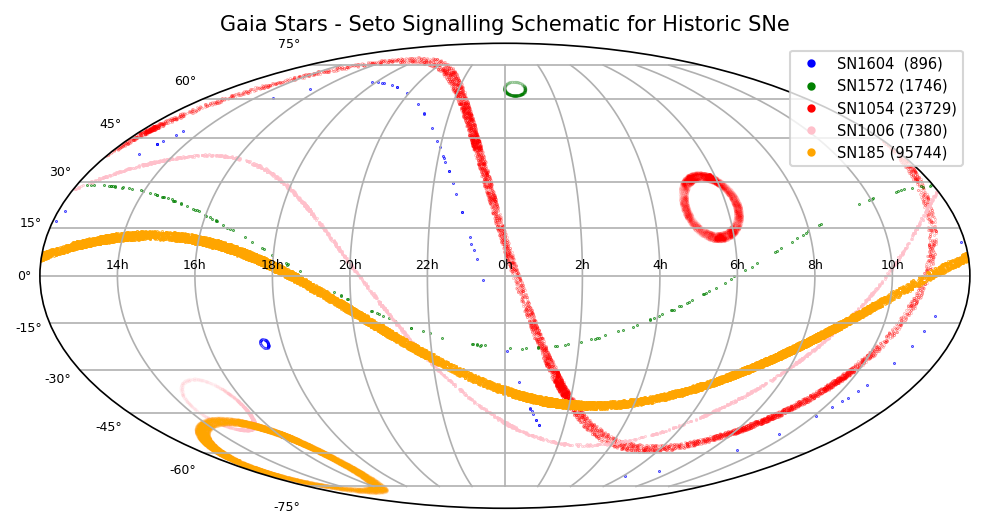

In [20]:
from matplotlib.lines import Line2D
legend_labels = [Line2D([0], [0], color='b', marker='.', lw=0, label=f'SN1604  ({len(ringPlusK)+len(ringMinusK)})'),
                Line2D([0], [0], color='g', marker='.', lw=0, label=f'SN1572 ({len(ringPlusT)+len(ringMinusT)})'),
                Line2D([0], [0], color='r', marker='.', lw=0, label=f'SN1054 ({len(ringPlusC)+len(ringMinusC)})'),
                Line2D([0], [0], color='pink', marker='.', lw=0, label=f'SN1006 ({len(ringPlus1006)+len(ringMinus1006)})'),
                Line2D([0], [0], color='orange', marker='.', lw=0, label=f'SN185 ({len(ringPlus185)+len(ringMinus185)})')]




fig = plt.figure(figsize=(8,5), dpi=150)
ax = fig.add_subplot(111, projection="mollweide")

ax.scatter(ringPlusC.ra.wrap_at(180*u.degree).radian, ringPlusC.dec.radian, c = 'r', s = 0.01)
ax.scatter(ringMinusC.ra.wrap_at(180*u.degree).radian, ringMinusC.dec.radian, c='r', s=0.0001)

ax.scatter(ringPlusK.ra.wrap_at(180*u.degree).radian, ringPlusK.dec.radian, c = 'b', s = 0.1)
ax.scatter(ringMinusK.ra.wrap_at(180*u.degree).radian, ringMinusK.dec.radian, c='b', s=0.0001)

ax.scatter(ringPlusT.ra.wrap_at(180*u.degree).radian, ringPlusT.dec.radian, c = 'g', s = 0.1)
ax.scatter(ringMinusT.ra.wrap_at(180*u.degree).radian, ringMinusT.dec.radian, c='g', s=0.0001)

ax.scatter(ringPlus1006.ra.wrap_at(180*u.degree).radian, ringPlus1006.dec.radian, c = 'pink', s = 0.1)
ax.scatter(ringMinus1006.ra.wrap_at(180*u.degree).radian, ringMinus1006.dec.radian, c='pink', s=0.0001)

ax.scatter(ringPlus185.ra.wrap_at(180*u.degree).radian, ringPlus185.dec.radian, c = 'orange', s = 0.1)
ax.scatter(ringMinus185.ra.wrap_at(180*u.degree).radian, ringMinus185.dec.radian, c='orange', s=0.0001)


ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.tick_params(axis='both', labelsize=6)
ax.grid(True)
ax.set_title('Gaia Stars - Seto Signalling Schematic for Historic SNe', fontsize=10)

ax.legend(handles=legend_labels, prop={'size': 7})

The above plot matches the theoretical plot in Seto (2021) below, as expected.

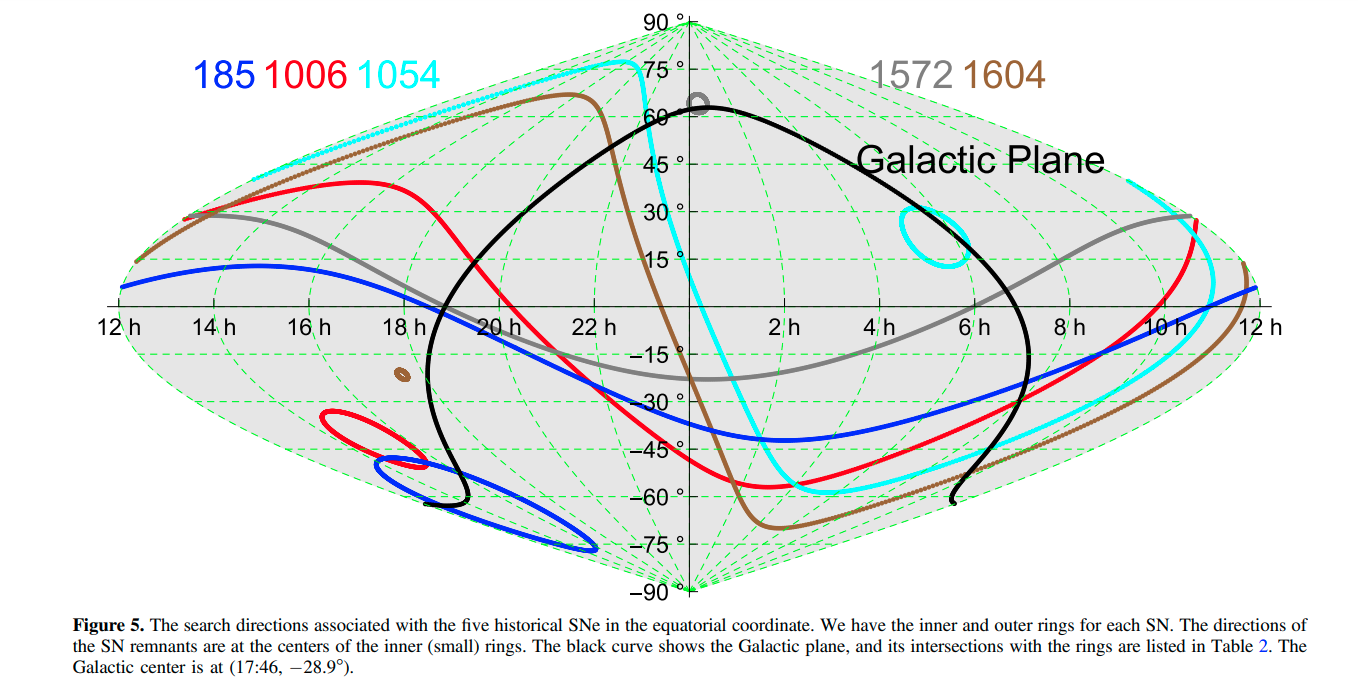

### Find crossing times for stars

In [21]:
from scipy.stats import binned_statistic, binned_statistic_2d
import cubehelix

CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [22]:
xtime = d0.to('m')/const.c*(np.cos(separations)+np.sin(separations)-1)

Select stars that are in the hemisphere centered on the SN and also within the search depth.

In [23]:
within = c1.distance.value < d0.value*np.cos(separations)
# we don't need to remove the stars with separation > 90 degrees manually, because their cosine values
# will be negative

In [24]:
H, xe, ye, bn = binned_statistic_2d(c1[within].ra.wrap_at(180*u.degree).radian, c1[within].dec.radian,
                                    values = xtime[within].to('yr').value + t0.decimalyear, 
                                    statistic='mean', bins=175) # mean binning for contours
XX, YY = np.meshgrid(xe, ye)

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)


/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)


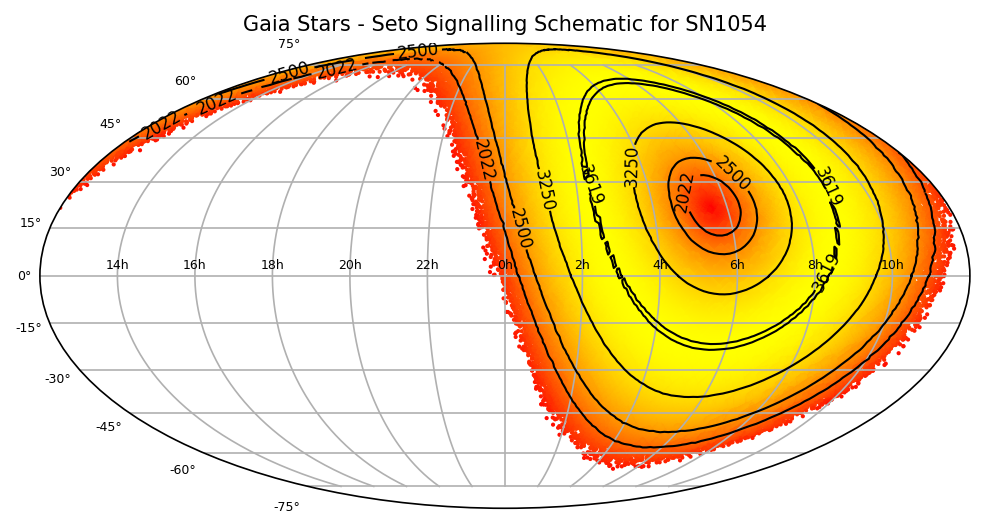

In [25]:
fig = plt.figure(figsize=(8,5), dpi=150)
ax = fig.add_subplot(111, projection="mollweide")


ax.scatter(c1[within].ra.wrap_at(180*u.degree).radian, c1[within].dec.radian,
            c=(xtime[within].to('yr').value + t0.decimalyear), cmap=plt.cm.autumn, rasterized=True, s=1)


maxYear = np.floor(((maxTauE*d0.to('m')/const.c).to('yr')+t0).decimalyear)-1
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=1, levels=[2022, 2500, 3250, maxYear]) # binned contours
plt.clabel(cs, fontsize=8)



ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.tick_params(axis='both', labelsize=6)
ax.grid(True)
ax.set_title('Gaia Stars - Seto Signalling Schematic for SN1054', fontsize=10)
plt.show()

All the above calculations for SN1054 can be done with a function in the `seto.py` script

In [216]:
c1K, xtimesK = seto.xtimes(cK, c1)
c1T, xtimesT = seto.xtimes(cT, c1)
c11006, xtimes1006 = seto.xtimes(c1006, c1)
c1185, xtimes185 = seto.xtimes(c185, c1)
c1A, xtimesA = seto.xtimes(cA, c1)

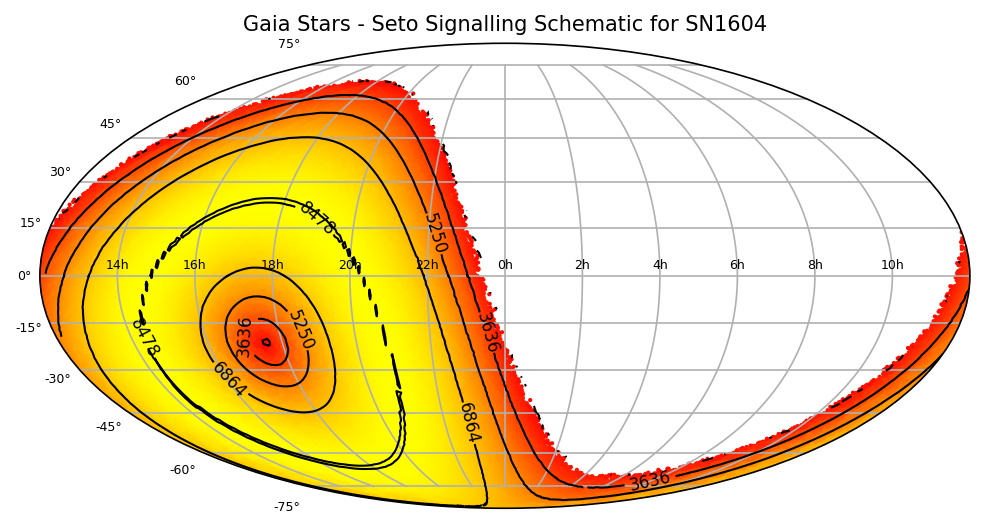

In [163]:
seto.plotXtimes(c1K, xtimesK, tK, cK,'1604')

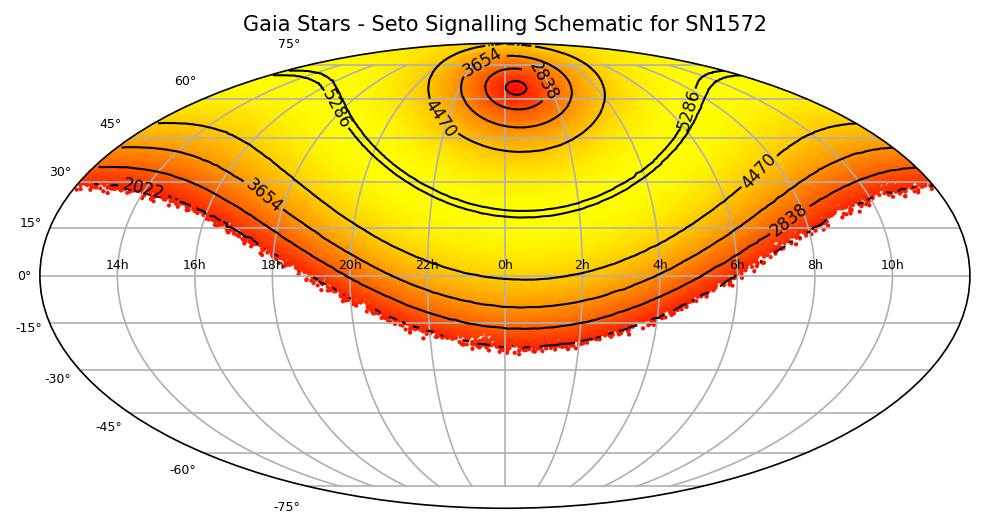

In [169]:
seto.plotXtimes(c1T, xtimesT, tT, cT, '1572')

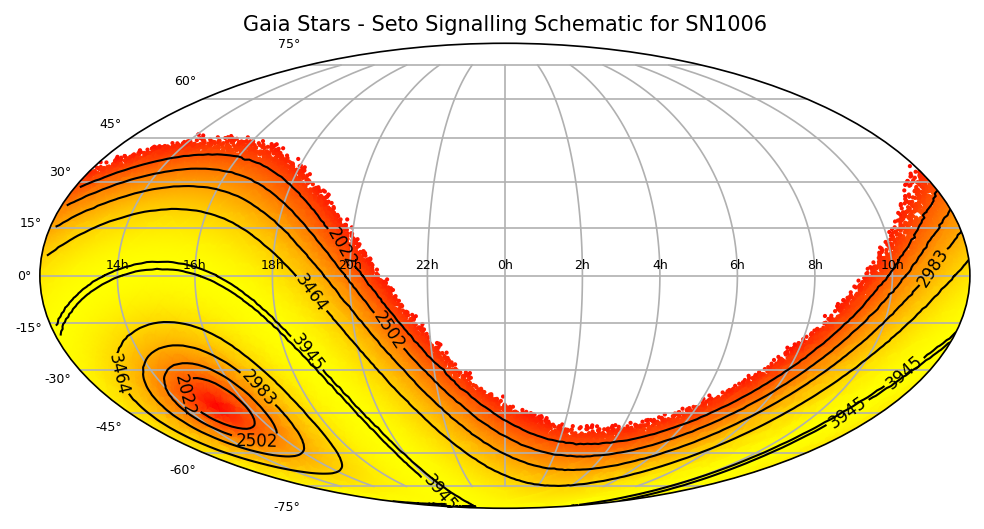

In [170]:
seto.plotXtimes(c11006, xtimes1006, t1006, c1006, '1006')

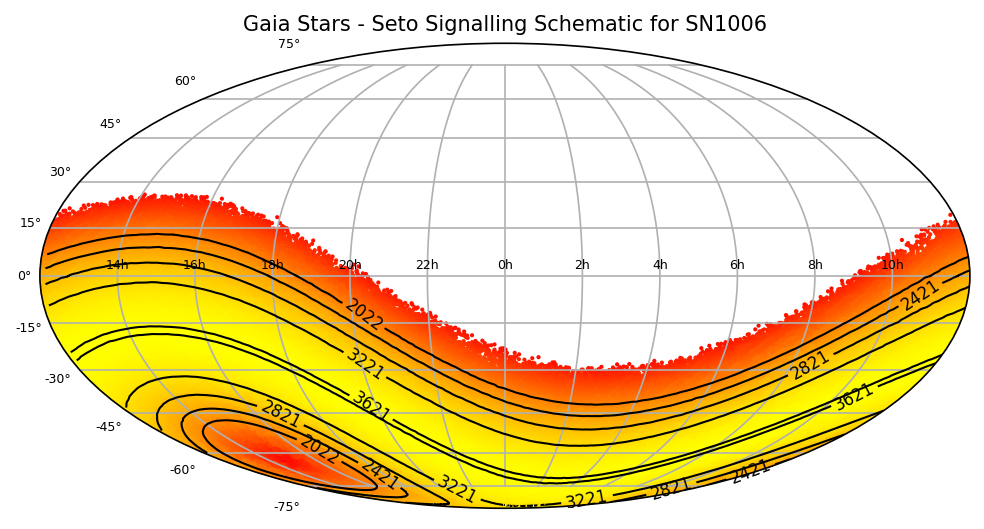

In [172]:
seto.plotXtimes(c1185, xtimes185, t185, c185, '1006')

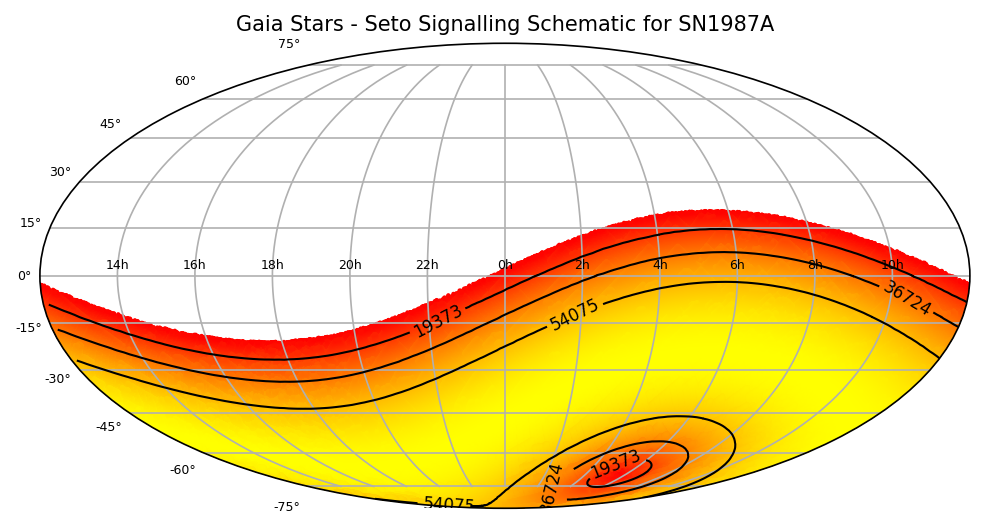

In [171]:
seto.plotXtimes(c1A, xtimesA, tA, cA, '1987A')

## Find stars crossing in the Gaia DR3 data time range

The start and end times are taken from the [Gaia DR3 content description](cosmos.esa.int/web/gaia/dr3)

In [205]:
startTime = Time('2014-07-25T10:30')
endTime = Time('2017-05-28T08:44')

In [211]:
startC, endC = startTime - t0, endTime - t0
inRangeC = (xtime[within].to('yr').value > startC.to('yr').value) & (xtime[within].to('yr').value < endC.to('yr').value)

In [187]:
(((dA_err.to('m')/const.c)*(np.cos(thetaMinus)+np.sin(thetaMinus)-1))).to('yr')

<Quantity 0.82756113 yr>

In [172]:
(((d0.to('m')/const.c)*(np.cos(thetaPlus)-np.sin(thetaPlus))*dTheta/u.rad)).to('yr')

<Quantity -122.64032915 yr>

This can also be done with a function in the `seto.py` script

In [200]:
import importlib
importlib.reload(seto)

<module 'seto' from '/mnt_home/anilipour/setiellipsoid/Gaia-DR3-SETI-Ellipsoid/seto.py'>

In [213]:
gaiaRingsK = seto.rings(cK, tK, c1, startTime, endTime)
gaiaRingsT = seto.rings(cT, tT, c1, startTime, endTime)
gaiaRings1006 = seto.rings(c1006, t1006, c1, startTime, endTime)
gaiaRings185 = seto.rings(c185, t185, c1, startTime, endTime)
gaiaRingsA = seto.rings(cA, tA, c1, startTime, endTime)

In [231]:
gaiaRingsA

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    []>

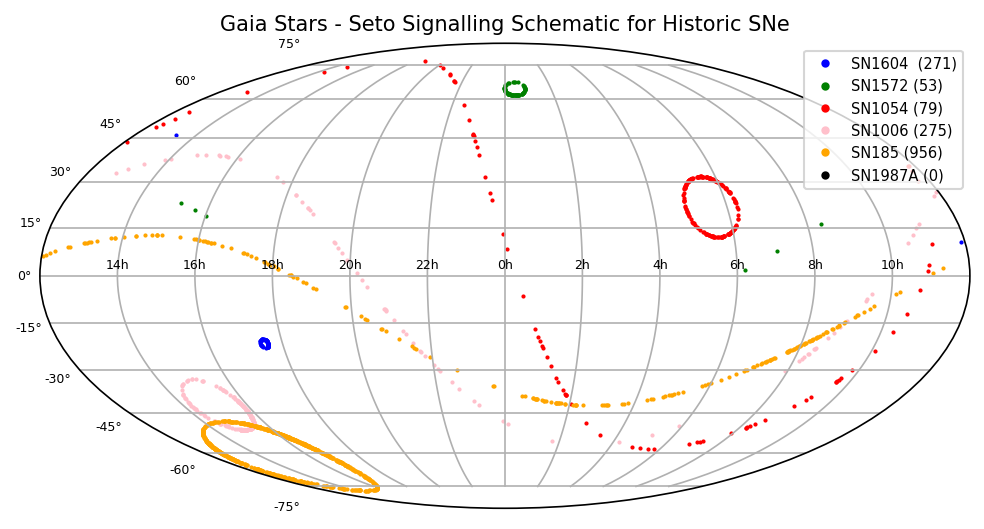

In [214]:
from matplotlib.lines import Line2D
legend_labels = [Line2D([0], [0], color='b', marker='.', lw=0, label=f'SN1604  ({np.sum(inRangeC)})'),
                Line2D([0], [0], color='g', marker='.', lw=0, label=f'SN1572 ({len(gaiaRingsK)})'),
                Line2D([0], [0], color='r', marker='.', lw=0, label=f'SN1054 ({len(gaiaRingsT)})'),
                Line2D([0], [0], color='pink', marker='.', lw=0, label=f'SN1006 ({len(gaiaRings1006)})'),
                Line2D([0], [0], color='orange', marker='.', lw=0, label=f'SN185 ({len(gaiaRings185)})'),
                Line2D([0], [0], color='black', marker='.', lw=0, label=f'SN1987A ({len(gaiaRingsA)})')]




fig = plt.figure(figsize=(8,5), dpi=150)
ax = fig.add_subplot(111, projection="mollweide")

ax.scatter(c1[within][inRangeC].ra.wrap_at(180*u.degree).radian, c1[within][inRangeC].dec.radian, c = 'r', s = 1)

ax.scatter(gaiaRingsK.ra.wrap_at(180*u.degree).radian, gaiaRingsK.dec.radian, c = 'b', s = 1)

ax.scatter(gaiaRingsT.ra.wrap_at(180*u.degree).radian, gaiaRingsT.dec.radian, c = 'g', s = 1)

ax.scatter(gaiaRings1006.ra.wrap_at(180*u.degree).radian, gaiaRings1006.dec.radian, c = 'pink', s = 1)

ax.scatter(gaiaRings185.ra.wrap_at(180*u.degree).radian, gaiaRings185.dec.radian, c = 'orange', s = 1)

ax.scatter(gaiaRingsA.ra.wrap_at(180*u.degree).radian, gaiaRingsA.dec.radian, c = 'orange', s = 1)


ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.tick_params(axis='both', labelsize=6)
ax.grid(True)
ax.set_title('Gaia Stars - Seto Signalling Schematic for Historic SNe', fontsize=10)

ax.legend(handles=legend_labels, prop={'size': 7})